In [1]:
import numpy as np
import h5py
import sys
import bisect

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:

class Histogram(object):
    """Histogram.
    """

    def __init__(self, values):
        """Create a histogram for the given values using the Freedman-Diaconis rule for the bin width.

        :param values: the values from which the histogram will be computed
        """
        self.num_instances = len(values)

        # Get the number of bins.
        v_min, v_25, v_75, v_max = np.percentile(values, [0, 25, 75, 100])
        # freedman_diaconis_width = 2 * (v_75 - v_25) / (len(values) ** (1/3.0))
        freedman_diaconis_width = (v_max - v_min) / (len(values) ** (1/3.0))
        num_bins = int(round((v_max - v_min) / freedman_diaconis_width))
        assert num_bins > 0

        # Fill the bins.
        self.heights, self.bin_edges = np.histogram(values, bins=num_bins)

    def find_bin(self, value):
        """Find the bin index of the given value.

        :param value: some value
        :return: bin index
        """
        bin_index = bisect.bisect_left(self.bin_edges, value) - 1
        bin_index = max(bin_index, 0)
        bin_index = min(bin_index, len(self.heights)-1)
        return bin_index

    def bin_probability(self, bin_index):
        """Return the bin probability of the desired bin.

        :param bin_index: index of the bin
        :return: probability of the bin
        """
        assert 0 <= bin_index <= len(self.heights) - 1
        return self.heights[bin_index] / float(self.num_instances)

class NaiveBayesClassifier(object):
    """Naive Bayes classifier.
    """

    def __init__(self):
        self.num_instances = None  # Number of instances that were used in training.
        self.num_feats = None  # Number of features that were used in training.
        self.classes = None  # The classes that were found in training.
        self.histograms = {}  # Dict with histograms, key: class, value: list with histograms for all features.
        self.priors = {}  # Dict with priors, key: class, value: prior of the class.

    def train(self, train_x, train_y):
        """Train the classifier.

        :param train_x: training x data
        :param train_y: training y data
        """
        assert train_x.shape[0] == len(train_y)
        self.num_instances = train_x.shape[0]
        self.num_feats = train_x.shape[1]
        self.classes = np.unique(train_y)

        # Create one histogram for each class and each feature.
        self.histograms.clear()
        self.priors.clear()
        for cl in self.classes:
            # Get the data of the current class.
            train_x_cl = [train_x[k] for k in range(self.num_instances) if train_y[k] == cl]
            num_instances_cl = len(train_x_cl)
            self.priors[cl] = num_instances_cl / float(self.num_instances)

            # Create one histogram per feature.
            self.histograms[cl] = []
            for i in range(self.num_feats):
                histo_points = [train_x_cl[k][i] for k in range(num_instances_cl)]
                self.histograms[cl].append(Histogram(histo_points))

    def probabilities_single(self, test_x):
        """Compute the class probabilities of a single instance.

        :param test_x: test x data of a single instance
        :return: probabilities of test_x for each class
        """
        assert len(test_x) == self.num_feats,\
            "NaiveBayesClassifier.probabilities_single(): Number of features in test and training must be the same."

        probs = {}
        for cl in self.classes:
            # Compute the likelihood.
            prob = self.priors[cl]
            for i in range(self.num_feats):
                # Find height of histogram bin with class cl that contains test_x[i].
                histo = self.histograms[cl][i]
                bin_index = histo.find_bin(test_x[i])
                prob *= histo.bin_probability(bin_index)
            probs[cl] = prob
        return probs

    def predict_single(self, test_x):
        """Predict the class of a single instance.

        :param test_x: test x data of a single instance
        :return: predicted class of test_x
        """
        probs = self.probabilities_single(test_x)
        max_cl = max(probs.keys(), key=lambda cl: probs[cl])
        return max_cl

    def predict(self, test_x):
        """Predict the classes of the given sample.

        :param test_x: test x data
        :return: predicted classes of test_x
        """
        assert test_x.shape[1] == self.num_feats,\
            "NaiveBayesClassifier.predict(): Number of features in test and training must be the same."
        return np.array([self.predict_single(test_x[i]) for i in range(test_x.shape[0])])

def print_error_rate(true_y, pred_y):
    """Prints the error rate of a prediction.

    :param true_y: true classes
    :param pred_y: predicted classes
    """
    assert len(true_y) == len(pred_y)
    correct = sum(1 for a, b in zip(true_y, pred_y) if a == b)
    total = len(true_y)
    rate = correct / float(total)
    print("The classification rate is %.02f (%d of %d were correct)." % (rate, correct, total))


def plot_compare(data_x, true_y, pred_y, title="Scatter Plot", legend=False, subplots=False):
    """Do a scatter plot of the data comparing the true and the predicted classes.

    Currently, only a 2 dimensional feature space and two classes are supported.
    :param data_x: n x d matrix with n instances of dimension d
    :param true_y: true classes
    :param pred_y: predicted classes
    :param title: title of the plot
    :param legend: show the legend
    :param subplots: use one subplot for each scatter plot
    """
    assert data_x.shape[0] == len(true_y) == len(pred_y)
    assert data_x.shape[1] == 2
    n = len(true_y)
    classes = np.unique(true_y)

    # Get the x and y coordinates of true/false positives/negatives.
    x_tp, y_tp = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] == pred_y[i] == classes[0]])
    x_tn, y_tn = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] == pred_y[i] == classes[1]])
    x_fp, y_fp = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] != pred_y[i] and pred_y[i] == classes[0]])
    x_fn, y_fn = zip(*[(data_x[i, 0], data_x[i, 1]) for i in range(n)
                       if true_y[i] != pred_y[i] and pred_y[i] == classes[1]])

    # Show the scatter plot.
    size = 20
    if subplots:
        # Use four subplots.
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (9,6))
        ax1.scatter(x_tp, y_tp, marker="x", c="b", s=size, label="tp")
        ax1.set_title("True positives")
        ax2.scatter(x_tn, y_tn, marker="o", c="b", s=size, label="tn")
        ax2.set_title("True negatives")
        ax3.scatter(x_fp, y_fp, marker="x", c="r", s=size, label="fp")
        ax3.set_title("False positives")
        ax4.scatter(x_fn, y_fn, marker="o", c="r", s=size, label="fn")
        ax4.set_title("False negatives")
        fig.tight_layout()
    else:
        # Plot all data in one diagram.
        plt.figure(figsize = (9,5))
        plt.title(title)
        plt.xlabel("First feature")
        plt.ylabel("Second feature")
        plt.scatter(x_tp, y_tp, marker="x", c="b", s=size, label="tp")
        plt.scatter(x_tn, y_tn, marker="o", c="b", s=size, label="tn")
        plt.scatter(x_fp, y_fp, marker="x", c="r", s=size, label="fp")
        plt.scatter(x_fn, y_fn, marker="o", c="r", s=size, label="fn")
        if legend:
            plt.legend(["tp", "tn", "fp", "fn"])
    plt.show()

# load digits data set
from sklearn.datasets import load_digits
from sklearn import model_selection

digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# extract only 3s and 9s
data_39 = data[np.logical_or(3 == target, 9 == target)]
target_39 = target[np.logical_or(3 == target, 9 == target)]

# function to reduce data set to two dimensions
def reduce_dim(x):
    feature1 = x[:, 26:27]
    feature2 = x[:, 22:23]
    
    reduced_x = np.concatenate([feature1, feature2], axis = 1)
    assert reduced_x.shape == (x.shape[0], 2)
    
    return reduced_x

reduced_data_39 = reduce_dim(data_39)

# split into train and test data
X_train, X_test, y_train , y_test =\
    model_selection.train_test_split(reduced_data_39, target_39, test_size = 0.4, random_state = 0)
print(X_train.shape, X_test.shape)

nb = NaiveBayesClassifier()

nb.train(X_train, y_train)
y_pred = nb.predict(X_test)

print_error_rate(y_test, y_pred)
#plot_compare(X_test, y_test, y_pred)
#plot_compare(X_test, y_test, y_pred, subplots = True)




(217, 2) (146, 2)
The classification rate is 0.85 (124 of 146 were correct).


In [3]:
f = h5py.File('./digits.h5')
images = f['images'].value
labels = f['labels'].value

f.close
print(images.shape)
print(labels.shape)

images[:8].shape

chosen_digit = 5
digit = images[np.where(labels==chosen_digit)]

fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(digit[im,:,:])
    
print(digit.shape)

(120000, 9, 9)
(120000,)
(10842, 9, 9)


In [4]:
def sample_naive_bayes(histograms, binning):
    """
    Generate new data from given histogram and binning information
    
    Parameters:
    -----------
        numpy.ndarray: histograms
        numpy.ndarray: binning
    
    Returns:
    --------
        numpy.ndarray: sampled_image
    """
    num_feat_dim = histograms.shape[0]
    
    pred_image = np.zeros(81)
    
    cum_histograms = np.cumsum(histograms,axis=1) #calculate cumulative probability distribution
    cum_histograms = (cum_histograms.T/cum_histograms[:,-1]).T # norm histogram
    #print(cum_histograms[0,:])
    selected_bins =  [bisect.bisect(cum_hist.flatten(),np.random.rand()) for cum_hist in cum_histograms]
    #print([((cum_hist.flatten()).shape) for cum_hist in cum_histograms])
    #print(selected_bins)
    pred_image = np.array([np.random.uniform(binning[pixel,bin_],binning[pixel,bin_+1]) for bin_,pixel in zip(selected_bins,range(len(selected_bins)))])
    
    
    return pred_image.reshape(9,9)

<IPython.core.display.Javascript object>


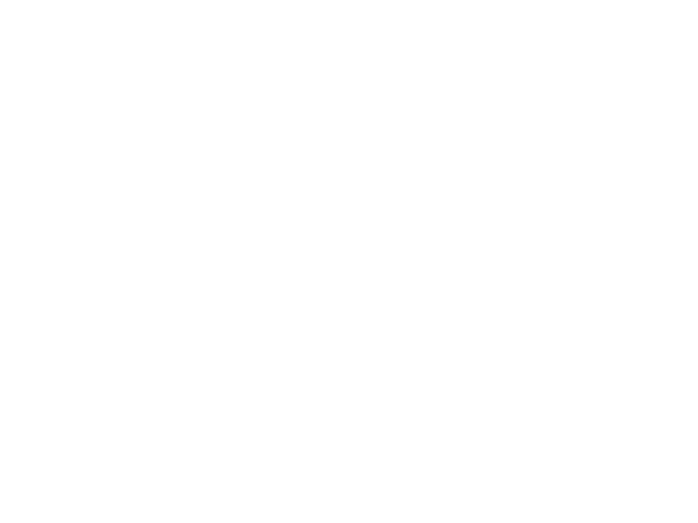

In [5]:
%matplotlib notebook
nb = NaiveBayesClassifier()
#flatten images:
digit_flat = digit.reshape(digit.shape[0],digit.shape[1]*digit.shape[2])


nb.train(digit_flat, np.ones(digit.shape[0],dtype=(int))*chosen_digit)

for _ in nb.histograms.values():
    histograms = np.squeeze(np.array([[__.heights] for __ in _]))  ### probability distr. for each feature dimension
    binning = np.squeeze(np.array([[__.bin_edges] for __ in _]))  ### bin edges for each feature dimension

sampled_images_nb = np.array([sample_naive_bayes(histograms,binning) for i in range(8)])
fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(sampled_images_nb[im,:,:])
    

/home/jan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: covariance is not positive-semidefinite.


<IPython.core.display.Javascript object>


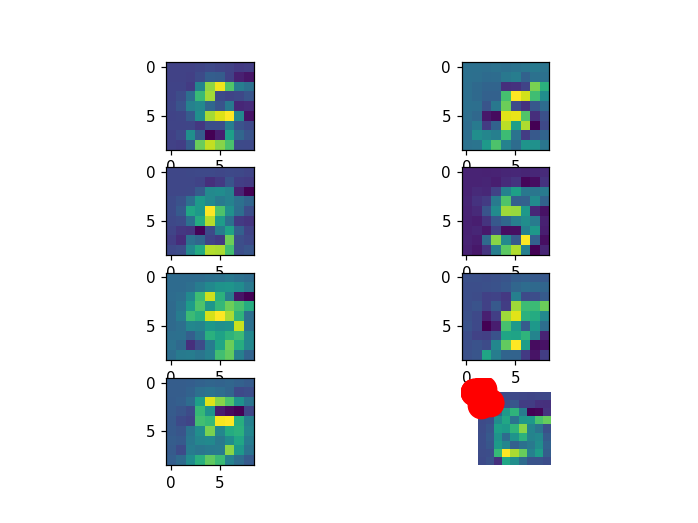

In [6]:
%matplotlib notebook
def fit_qda(training_features):
    """
    Fits D dimensional Gaussian to the given training data.
    
    
    Input N x D vector of training features
    Returns 2 x D matrix of means of the 2 classes, 2 x D x D array of the covariances"""
    
    def vec_generator(matrix):
        """ Returns one vector at a time"""
        for i in range(len(matrix[:,0])):
            yield matrix[i,:]
   
    mu = np.mean(training_features,axis=0)
    covmat = np.mean([np.outer(i,j) for i,j in zip(vec_generator(training_features-mu), vec_generator(training_features-mu))],axis=0)
    return mu, covmat

mu, covmat = fit_qda(digit_flat)
sampled_images_qda = np.array([np.random.multivariate_normal(mu,covmat).reshape(9,9) for i in range(8)])
fig, axes = plt.subplots(4,2)
for ax,im in zip(axes.flatten(),range(8)):
    ax.imshow(sampled_images_qda[im,:,:])


## 2.1
ToDo: Discretize each feature in 10 equally spaced thresholds. Search for cutpoint that minimizes score function score: $score = error_{before} - error_{after split} = -p_{l}²V_{l}+p_{\rho}²V_{\rho}+p_{\lambda}²V_{\lambda}$
Before performing the split, check out all threshold * feature possibilities and choose where we get the highest gain in information


Keep track of bounding box for each bin, scores

In [187]:
import heapq
import networkx as nx

heap_score = [] #keep track leaf ranking according to scores

tree = nx.Graph()
tree.add_node(0)
def fit_density_tree1(features, bincount):
    """Creates density tree with bincount leaves
    
    Parameters:
    -----------
    numpy.ndarray: features (N x D)
    int: bincount
    """
    N = features.shape[0]
    def score_func(features):
        """Calculate score function (error) for feature dimensions
        
        Parameters:
        -----------
            numpy.ndarray: features (N* x D)"""
        D = features.shape[1]
        error = np.zeros((D,10))
        split = np.zeros((D,10))
        N_0 = features.shape[0] #total features before splitting
        max_ = np.amax(features,axis=0)
       
       
        min_ = np.amin(features,axis=0)

        ### the following loops calculate the error (the information change) for each feature dimension discretized into 10 regions
        for dimcount in np.arange(D):
            if max_[dimcount] != min_[dimcount]:
                V_reduced = np.prod( (max_-min_) [np.arange(D)!=dimcount]) # Volume / length of current feature dimension that we look at
                discretized_features = np.linspace(min_[dimcount]+(max_-min_)[dimcount]/10 , max_[dimcount]-(max_-min_)[dimcount]/10 , 10 ) #divide current feature dimension into 10 equal parts
                
                print(V_reduced)

                for idx, _ in enumerate(discretized_features):
                        N_1 = features[np.where(features[:,dimcount] <= _)].shape[0]
                        N_2 = N_0 - N_1
                        V_0 = (max_-min_)[dimcount] 
                        V_1 = (_ - min_[dimcount]) 
                        V_2 = (max_[dimcount] - _) 
                        error[dimcount,idx] = ( - ( N_0 / N )**2 / V_0 +  ( N_1 / N )**2 / V_1 + ( N_2 / N)**2 / V_2) / V_reduced
                        split[dimcount,idx] = _
                        
            else:
                error[dimcount,:] = 10**30
        ### choose cutpoint, volume according to lowest error
        (row_idx,col_idx) = np.unravel_index(error.argmin(),error.shape)
        cut_point = split[row_idx,col_idx]
        return row_idx, cut_point, error[row_idx,col_idx]
    
    
    
    
    return score_func(features)

def perform_split(features,dimension,cut_point):
        print(features.shape)
        left = np.where(features[:,dimension]<=cut_point)
        print(left[0].shape)
        right = np.where(features[:,dimension]>cut_point)
        return features[left], features[right]
    
    
def bounding_box(min_,max_,cut_point,dimension):
        return
        

In [189]:
row, cut, error = fit_density_tree1(digit_flat/100,10)
left, right = perform_split(digit_flat,row,cut)

8.936777001e+16
2.87833745657e+16
6.50042406896e+15
5.43395413999e+15
4.0542645011e+15
4.15123501285e+15
3.35298247007e+15
3.86023505853e+15
5.16937086879e+15
3.17241027101e+16
1.4594288793e+16
4.45374914456e+15
2.28544326604e+15
1.67850780808e+15
1.60952811359e+15
1.55906064441e+15
1.58955055998e+15
1.61167399379e+15
1.18809616434e+16
4.17210099476e+15
1.56384317639e+15
1.53282664057e+15
1.52650754109e+15
1.52279749107e+15
1.52238036384e+15
1.52171515931e+15
1.52472530146e+15
8.385805677e+15
2.57340559042e+15
1.54907891135e+15
1.52559872601e+15
1.52176326294e+15
1.5222983586e+15
1.52535694798e+15
1.52490901152e+15
1.53720556016e+15
6.74538838768e+15
2.04958840116e+15
1.52331048196e+15
1.5217161901e+15
1.5217161901e+15
1.5217161901e+15
1.5269701377e+15
1.5381802314e+15
1.56095455319e+15
5.42507146043e+15
1.81310154615e+15
1.52971948943e+15
1.5217161901e+15
1.5217161901e+15
1.52803769477e+15
1.53093971827e+15
1.53385789085e+15
1.59207943672e+15
5.34097439732e+15
1.8360426272e+15
1.53451

In [190]:
for i in range(10):
    row, cut, error = fit_density_tree1(left,10)
    left, right = perform_split(left,row,cut)
    print(left.shape, right.shape)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(108, 81)
(78,)
(78, 81) (30, 81)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(78, 81)
(78,)
(78, 81) (0, 81)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

/home/jan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars
/home/jan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(78, 81)
(78,)
(78, 81) (0, 81)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(78, 81)
(78,)
(78, 81) (0, 81)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(78, 81)
(78,)
(78, 81) (0, 81)
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [139]:
row, cut, error

(0, 0.43420267105102539, 0.0)